### Bibliotecas

In [18]:
# tratamento de dados
import pandas as pd
import numpy as np

# dataviz
import seaborn as sns
import matplotlib.pyplot as plt

# ML
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, ARIMA, Naive, SeasonalNaive, SeasonalWindowAverage, WindowAverage
from statsforecast.utils import ConformalIntervals

import joblib

import warnings
warnings.filterwarnings('ignore')

### Importando os dados

In [19]:
# lendo os dados
df_petroleo = pd.read_csv(r'https://raw.githubusercontent.com/torvess/Tech_Challeng_FIAP_Fase_04/refs/heads/main/Dados/dados_petroleo.csv')

In [20]:
# conhecendo os dados
print(f'Número de linhas: {df_petroleo.shape[0]:,}')
print(f'Número de colunas: {df_petroleo.shape[1]}')

print('                                          ')

print(f'Data mínima: {df_petroleo.data.min()}')
print(f'Data máxima: {df_petroleo.data.max()}')

Número de linhas: 11,278
Número de colunas: 2
                                          
Data mínima: 1987-05-20
Data máxima: 2024-10-15


In [21]:
df_petroleo.head(3)

,data,preco
0,2024-10-15,73.68
1,2024-10-12,78.47
2,2024-10-11,80.27


In [22]:
# nenhum valor nulo
df_petroleo.isnull().sum().sum()

0

In [23]:
# nenhum valor duplicado
df_petroleo.duplicated().sum().sum()

0

In [24]:
# verificando os tipos de dados
df_petroleo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11278 entries, 0 to 11277
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   data    11278 non-null  object 
 1   preco   11278 non-null  float64
dtypes: float64(1), object(1)
memory usage: 176.3+ KB


In [25]:
df_petroleo['data'] = pd.to_datetime(df_petroleo['data'], format='%Y-%m-%d')

### Análise exploratória dos dados

In [26]:
# criando um df para fazer alteraçoes
dados_petroleo = df_petroleo.copy()

In [27]:
dados_petroleo = dados_petroleo[dados_petroleo['data'] <= pd.to_datetime('2023-12-31')]

In [28]:
dados_petroleo.head(3)

,data,preco
201,2023-12-29,77.69
202,2023-12-28,79.04
203,2023-12-27,80.97


In [29]:
dados_petroleo.tail(2)

,data,preco
11276,1987-05-21,18.45
11277,1987-05-20,18.63


In [30]:
dias_da_semana = {
    0: 'segunda-feira',
    1: 'terça-feira',
    2: 'quarta-feira',
    3: 'quinta-feira',
    4: 'sexta-feira',
    5: 'sábado',
    6: 'domingo'
}

# criando colunas necessarias para a analise
dados_petroleo = dados_petroleo.assign(
                                    semana_ano = dados_petroleo.data.dt.isocalendar().week,
                                    dia_semana = dados_petroleo.data.dt.isocalendar().day,
                                    nome_dia = dados_petroleo.data.dt.isocalendar().day.apply(lambda x: dias_da_semana.get(x)),
                                    ano = dados_petroleo.data.dt.isocalendar().year,
                                    mes = dados_petroleo.data.dt.month,
                                    nome_mes = dados_petroleo.data.dt.strftime('%B')
                                        )

# reordenando as colunas
dados_petroleo = dados_petroleo[['ano', 'mes', 'nome_mes', 'semana_ano', 'dia_semana', 'nome_dia', 'data', 'preco']]

In [31]:
dados_petroleo.head(2)

,ano,mes,nome_mes,semana_ano,dia_semana,nome_dia,data,preco
201,2023,12,December,52,5,sábado,2023-12-29,77.69
202,2023,12,December,52,4,sexta-feira,2023-12-28,79.04


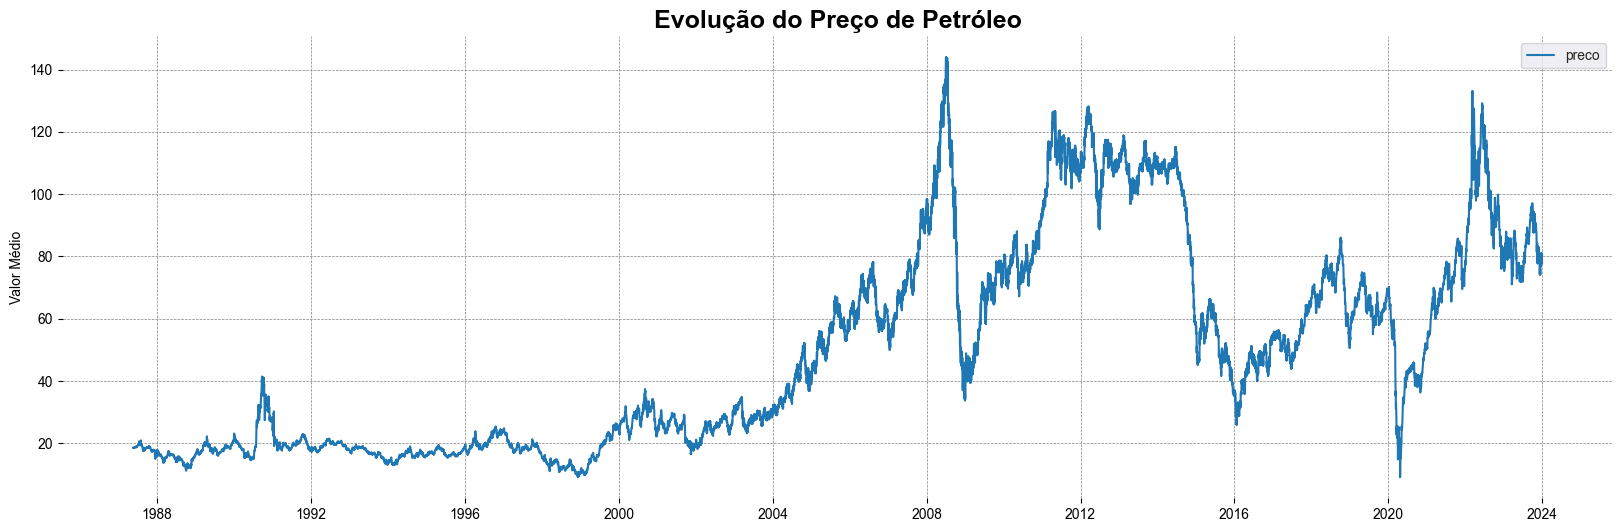

In [32]:
# tamanho da figura
fig, ax = plt.subplots(figsize=(20, 6))
# tema do fundo
sns.set_style("darkgrid")
# formatando os grids
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

# plotando informaçoes do grafico
ax = sns.lineplot(data=dados_petroleo.groupby('data').agg({'preco':'mean'}))
ax.set_title('Evolução do Preço de Petróleo', fontsize=18, weight='bold')
ax.set_ylabel('Valor Médio')
ax.set_xlabel('')

plt.show()

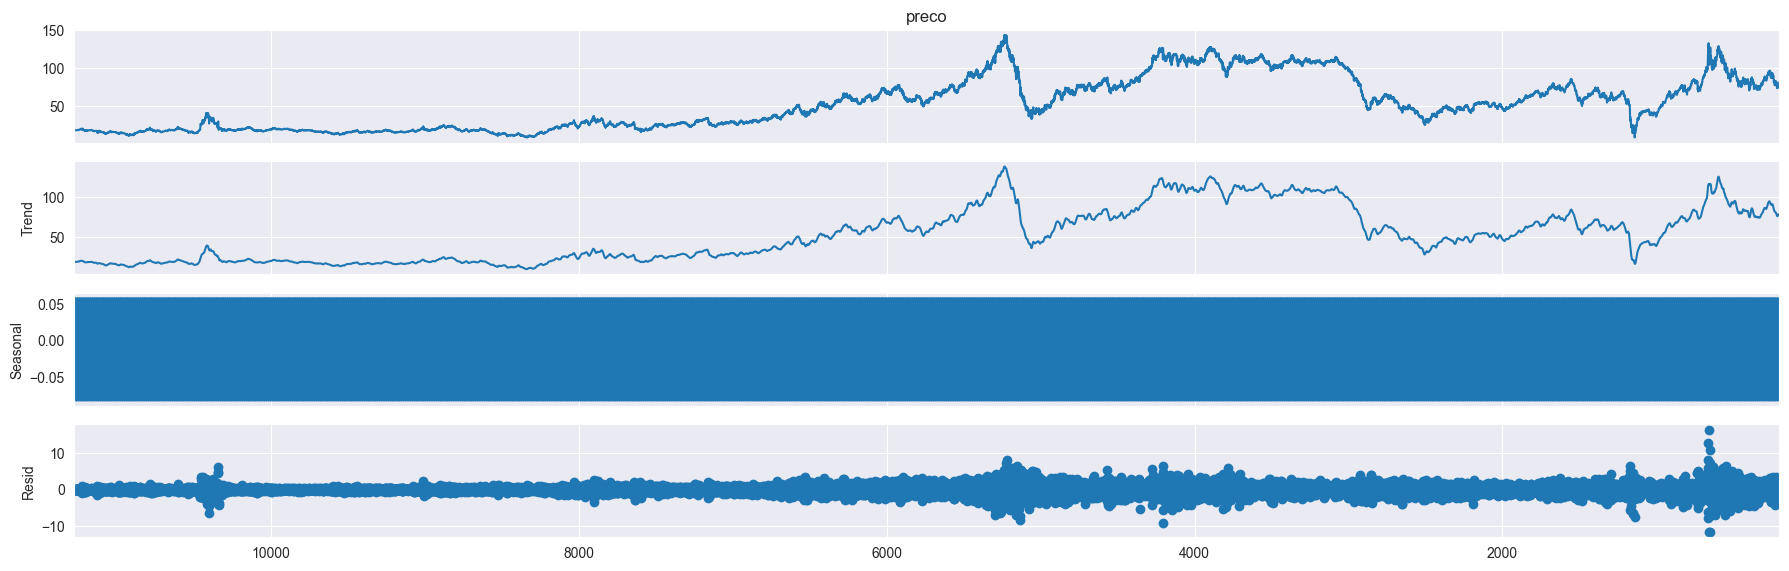

In [33]:
dados_petroleo = dados_petroleo.sort_values(by='data')
decomposicao = seasonal_decompose(dados_petroleo['preco'], model='additive', period=12)

fig = decomposicao.plot()
fig.set_size_inches(20, 6)
plt.show()

Analisando a serie no decorrer do tempo, tivemos tendências contrarias em períodos diferentes.

* Entre 2005 e 2009 forte tendência de aumento de preços seguido por uma queda brusca
* Entre 2010 e 2012 novo aumento seguido por 3 anos sem queda ou novos aumentos
* 2015 novos aumentos que seguiram até 2020
* Entre 2020 e 2023 nova tendência de aumento seguido por queda


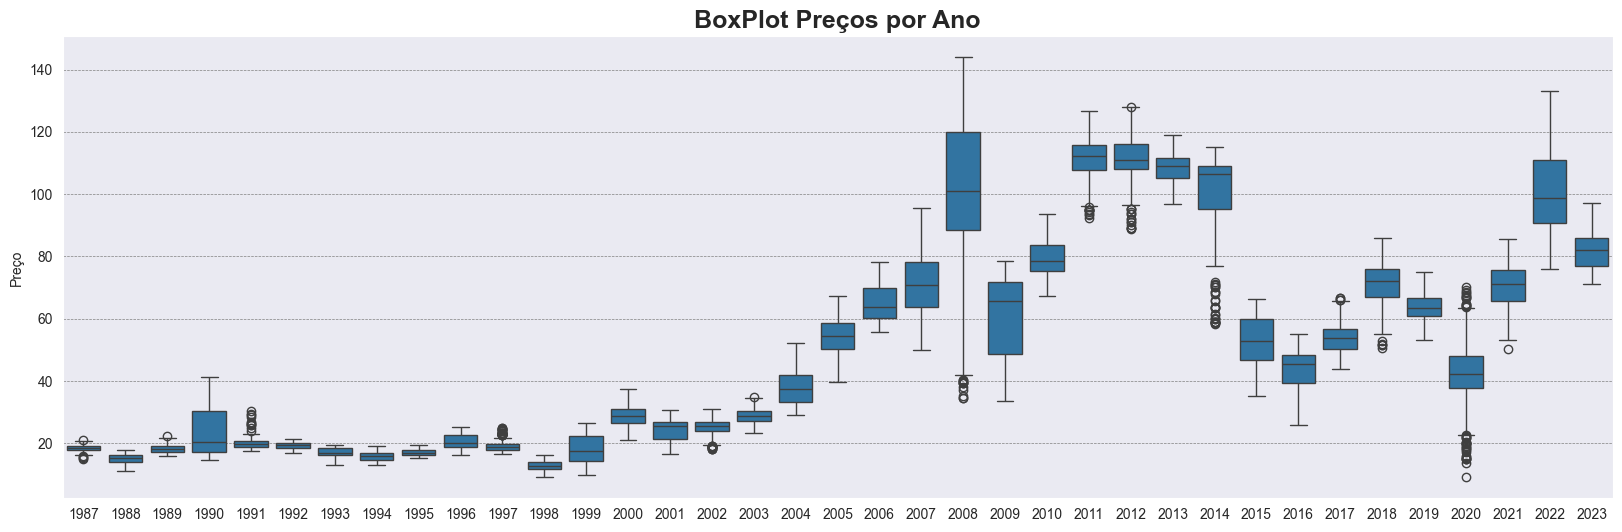

In [34]:
# tamanho da figura
fig, ax = plt.subplots(figsize=(20, 6))
# tema do fundo
sns.set_style("darkgrid")
# formatando os grids
plt.grid(color='gray', linestyle='--', linewidth=0.5)

ax = sns.boxplot(data=dados_petroleo, x='ano', y='preco')
ax.set_title('BoxPlot Preços por Ano', fontsize=18, weight='bold')
ax.set_ylabel('Preço')
ax.set_xlabel('')

plt.show()

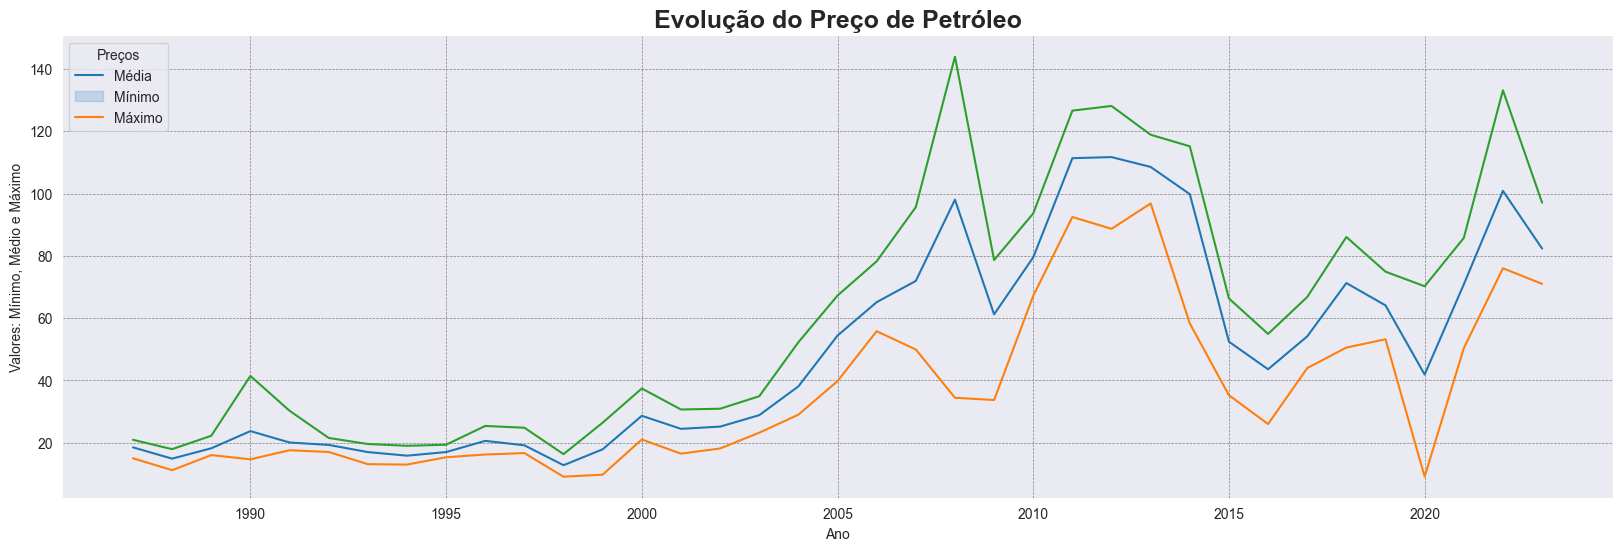

In [35]:
# Plotando o gráfico de evolução do preço do petróleo
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

# Agrupando os dados por ano e calculando as estatísticas
dados_agrupados = dados_petroleo.groupby('ano').agg({'preco': ['mean', 'min', 'max']}).reset_index()

# Plotando o gráfico
ax = sns.lineplot(data=dados_agrupados, x='ano', y=('preco', 'mean'), label='Média')
ax = sns.lineplot(data=dados_agrupados, x='ano', y=('preco', 'min'), label='Mínimo')
ax = sns.lineplot(data=dados_agrupados, x='ano', y=('preco', 'max'), label='Máximo')

ax.set_title('Evolução do Preço de Petróleo', fontsize=18, weight='bold')
ax.set_ylabel('Valores: Mínimo, Médio e Máximo')
ax.set_xlabel('Ano')

# Adicionando a legenda
ax.legend(title='Preços', labels=['Média', 'Mínimo', 'Máximo'], loc='upper left')

plt.show()


In [36]:
# verificando se a série é estacionária
class VerificaEstacionaridade():
    def __init__(self, data, column):
        self.data = data
        self.column = column

    # analisando se a série é estacionária
    def adf_test(self):
        adf_result = adfuller(self.data[self.column])
        print("Teste ADF:")
        print(f"p-valor: {adf_result[1]}")
        if adf_result[1] >= 0.05:
            print('A série não é estacionária')
        else:
            print('A série é estacionária')

    def kpss_test(self):
        kpss_result = kpss(self.data[self.column], regression="c")
        print("\nTeste KPSS:")
        print(f"p-valor: {kpss_result[1]}")
        if kpss_result[1] <= 0.05:
            print('A série não é estacionária')
        else:
            print('A série é estacionária')

In [37]:
dados_teste = VerificaEstacionaridade(dados_petroleo, 'preco')
dados_teste.adf_test()
dados_teste.kpss_test()

Teste ADF:
p-valor: 0.24680667532234557
A série não é estacionária

Teste KPSS:
p-valor: 0.01
A série não é estacionária


Visto que a série não é estacionária, é preciso utilizar modelos que levem em consideração:

* Tendência
* Sazonalidade
* Ruídos

### Seleção das features

In [38]:
# copia para preservar o df
dados_ml = dados_petroleo.copy()

# seleção de colunas numéricas
dados_ml = dados_ml[['data', 'preco']]

dados_ml.head(2)

,data,preco
11277,1987-05-20,18.63
11276,1987-05-21,18.45


### Escolhendo o melhor modelo

In [39]:
# validação dos modelos
def wmape(y_true, y_pred):
    return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

In [40]:
# treino e teste para validaçao dos modelos
treino = dados_ml[:-15][['data', 'preco']]
treino.rename(columns={'data':'ds', 'preco':'y'}, inplace=True)
treino['unique_id'] = 'serie_unica'

teste = dados_ml[-15:][['data', 'preco']]
teste.rename(columns={'data':'ds', 'preco':'y'}, inplace=True)
teste['unique_id'] = 'serie_unica'

h = len(teste)

wmape: 4.43%
Percentual de acerto 95.57%


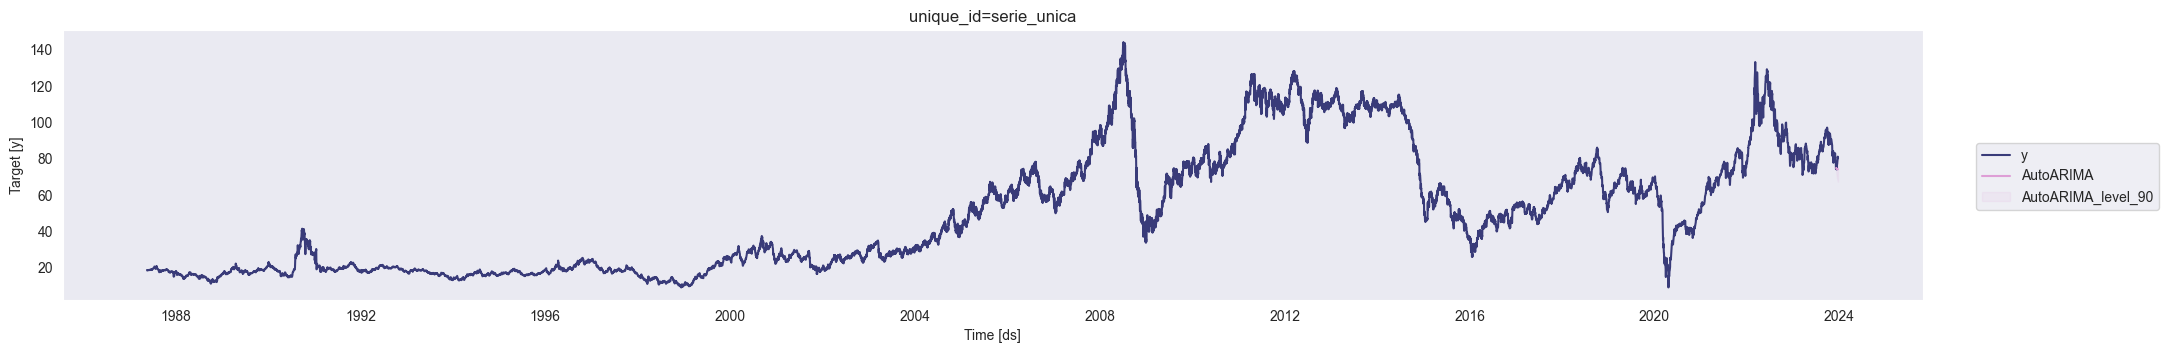

In [41]:
model_a = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
model_a.fit(treino)

forecast_dados = model_a.predict(h=h, level=[90])
forecast_dados = forecast_dados.reset_index().merge(teste, on=['ds', 'unique_id'], how='inner')

wmape_arima = wmape(forecast_dados['y'].values, forecast_dados['AutoARIMA'].values)
print(f'wmape: {wmape_arima:.2%}')
print(f'Percentual de acerto {1- wmape_arima:.2%}')

model_a.plot(treino, forecast_dados, level=[90], engine= 'matplotlib')

wmape: 4.81%
Percentual de acerto 95.19%


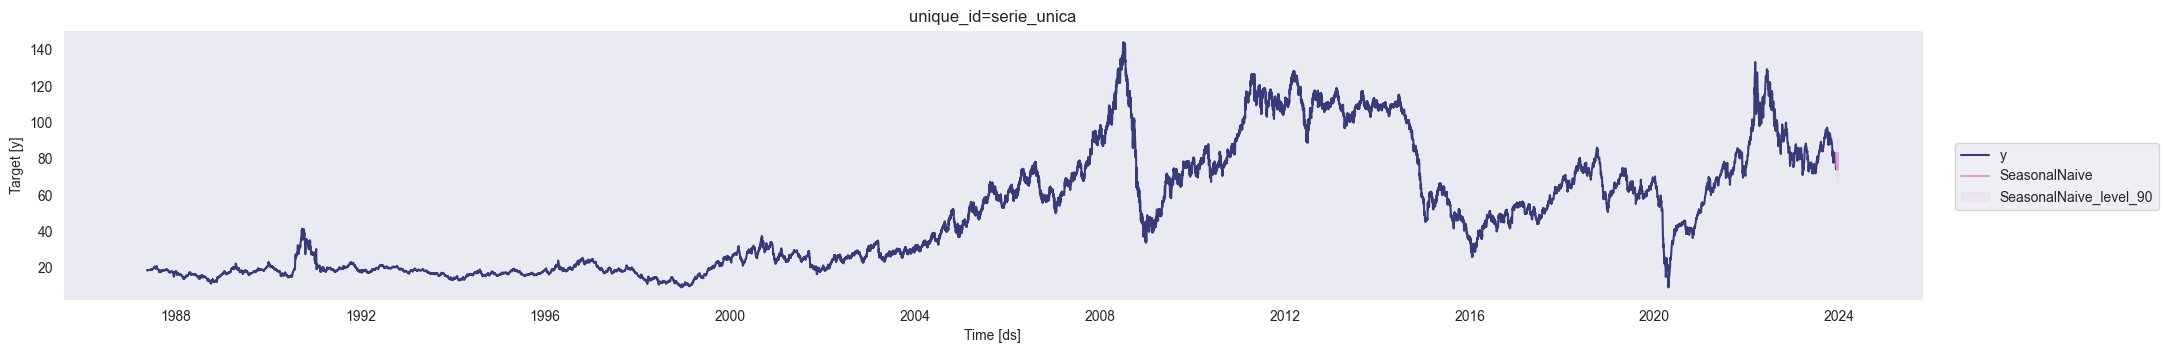

In [42]:
model_s = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D', n_jobs=-1)
model_s.fit(treino)

forecast_dados_s = model_s.predict(h=h, level=[90])
forecast_dados_s = forecast_dados_s.reset_index().merge(teste, on=['ds', 'unique_id'], how='inner')

wmape_sn = wmape(forecast_dados_s['y'].values, forecast_dados_s['SeasonalNaive'].values)
print(f'wmape: {wmape_sn:.2%}')
print(f'Percentual de acerto {1- wmape_sn:.2%}')

model_s.plot(treino, forecast_dados_s, level=[90],engine ='matplotlib')

WMAPE: 4.34%
Percentual de acerto 95.66%


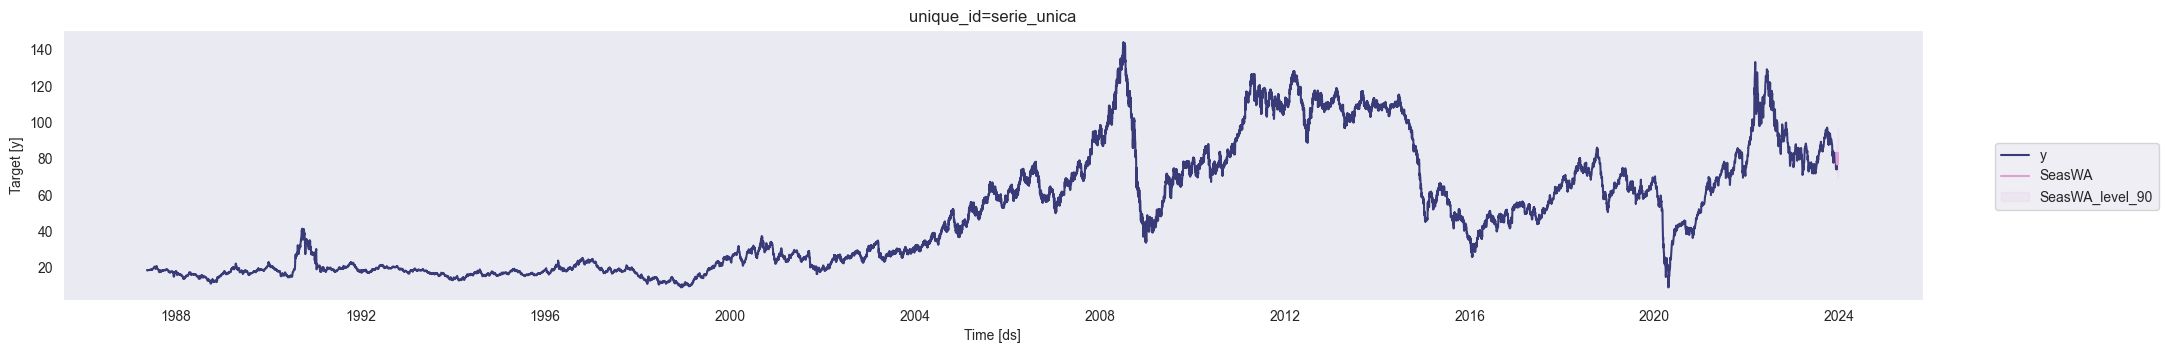

In [43]:
intervals = ConformalIntervals(h=h, n_windows=2)


model_sm = StatsForecast(models=[SeasonalWindowAverage(season_length=7, window_size=2, prediction_intervals=intervals)], freq='D', n_jobs=-1)
model_sm.fit(treino)

forecast_dados_sm = model_sm.predict(h=h, level=[90])
forecast_dados_sm = forecast_dados_sm.reset_index().merge(teste, on=['ds', 'unique_id'], how='inner')

wmape_swa = wmape(forecast_dados_sm['y'].values, forecast_dados_sm['SeasWA'].values)
print(f"WMAPE: {wmape_swa:.2%}")
print(f'Percentual de acerto {1- wmape_swa:.2%}')

model_sm.plot(treino, forecast_dados_sm, level=[90], engine ='matplotlib')

### Pipeline

In [44]:
# classe para preparação dos dados
class PreProcessData:
    def __init__(self, data):
        self.data = data
        self.model_SeasonalNaive = None

    # tratamento do df
    def preprocess_data(self):
        self.data['data'] = pd.to_datetime(self.data['data'], format='%Y-%m-%d')
        self.data['unique_id'] = 'serie_unica'
        self.data.rename(columns={'data':'ds', 'preco':'y'}, inplace=True)
        self.data.dropna(inplace=True)
        self.data = self.data[['ds', 'y', 'unique_id']].reset_index(drop=True)
        return self.data

# classe para divisão de treino e teste
class SplitTrainTeste:
    def __init__(self, data):
        self.data = data
        self.train = None
        self.test = None
        self.h = None

    # divisão treino e teste
    def split_train_teste(self):
        self.train = self.data[:-15].dropna()
        self.test = self.data[-15:].dropna()
        self.h = len(self.test.index)
        print(f'{len(self.train):,} valores para treino')
        print(f'{len(self.test):,} valores para teste')
        return self.train, self.test, self.h


# classe para instanciar o modelo
class ModelSeasonalNaive():
    def __init__(self, train_data, h):
        self.train_data = train_data
        self.h = h

    # treinamento a aplicacao dos modelos
    def fit_SeasonalNaive(self):
        self.model_SeasonalNaive = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D', n_jobs=-1)
        self.model_SeasonalNaive.fit(self.train_data)
        print('Treinamento concluído')

    def predic_SeasonalNaive(self, date):
        self.h = (pd.Timestamp(date) - self.train_data['ds'].max()).days
        forecast = self.model_SeasonalNaive.predict(h=self.h, level=[90])
        return  forecast[forecast['ds'] == date]['SeasonalNaive'].values[0]

In [45]:
# processando os dados
dados_model = dados_ml.copy()
processar_dados = PreProcessData(dados_model)
dados_model = processar_dados.preprocess_data()

display(dados_model.head(2))

,ds,y,unique_id
0,1987-05-20,18.63,serie_unica
1,1987-05-21,18.45,serie_unica


In [46]:
# dividindo em treino e teste
split = SplitTrainTeste(dados_model)
train, test, h = split.split_train_teste()

11,062 valores para treino
15 valores para teste


In [47]:
# treinando o modelo
model_sv = ModelSeasonalNaive(train, h)
model_sv.fit_SeasonalNaive()

Treinamento concluído


In [48]:
# prevendo valores
model_sv.predic_SeasonalNaive('2024-11-27')

74.33

In [52]:
# salvando o modelo
joblib.dump(model_sv, r'D:\Documentos\FIAP - Pos Tech Data Analytics\Tech Challeng - Preços Petróleo\Tech_Challeng_FIAP_Fase_04\Modelos\SeasonalNaive.joblib')

['D:\\Documentos\\FIAP - Pos Tech Data Analytics\\Tech Challeng - Preços Petróleo\\Tech_Challeng_FIAP_Fase_04\\Modelos\\SeasonalNaive.joblib']

In [50]:
# testando o modelo salvo
model_t = joblib.load(r'D:\Documentos\FIAP - Pos Tech Data Analytics\Tech Challeng - Preços Petróleo\Tech_Challeng_FIAP_Fase_04\Modelos\SeasonalNaive.joblib')
model_t.predic_SeasonalNaive('2024-11-27')

74.33